In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("dataset/sensor_LSTM.csv")
data

,Unnamed: 0,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,machine_status
0,0,2018-04-01 0:00,634.375000,13.41146,16.13136,15.56713,15.05353,NORMAL
1,1,2018-04-01 0:01,634.375000,13.41146,16.13136,15.56713,15.05353,NORMAL
2,2,2018-04-01 0:02,638.888900,13.32465,16.03733,15.61777,15.01013,NORMAL
3,3,2018-04-01 0:03,628.125000,13.31742,16.24711,15.69734,15.08247,NORMAL
4,4,2018-04-01 0:04,636.458300,13.35359,16.21094,15.69734,15.08247,NORMAL
...,...,...,...,...,...,...,...,...
220315,220315,2018-08-31 23:55,634.722229,15.11863,16.65220,15.65393,15.16204,NORMAL
220316,220316,2018-08-31 23:56,630.902771,15.15480,16.70284,15.65393,15.11863,NORMAL
220317,220317,2018-08-31 23:57,625.925903,15.08970,16.70284,15.69734,15.11863,NORMAL
220318,220318,2018-08-31 23:58,635.648100,15.11863,16.56539,15.74074,15.11863,NORMAL


In [3]:
data.shape

(220320, 8)

In [4]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'sensor_04', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'machine_status'],
      dtype='object')

In [5]:
data.head()

,Unnamed: 0,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,machine_status
0,0,2018-04-01 0:00,634.3750,13.41146,16.13136,15.56713,15.05353,NORMAL
1,1,2018-04-01 0:01,634.3750,13.41146,16.13136,15.56713,15.05353,NORMAL
2,2,2018-04-01 0:02,638.8889,13.32465,16.03733,15.61777,15.01013,NORMAL
3,3,2018-04-01 0:03,628.1250,13.31742,16.24711,15.69734,15.08247,NORMAL
4,4,2018-04-01 0:04,636.4583,13.35359,16.21094,15.69734,15.08247,NORMAL


In [6]:
data.describe()

,Unnamed: 0,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09
count,220320.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000
mean,110159.500000,590.673936,13.501537,15.843152,15.200721,14.799210
std,63601.049991,144.023912,2.163736,2.201155,2.037390,2.091963
min,0.000000,2.798032,0.014468,0.000000,0.028935,0.000000
25%,55079.750000,626.620400,13.346350,15.907120,15.183740,15.053530
50%,110159.500000,632.638916,13.642940,16.167530,15.494790,15.082470
75%,165239.250000,637.615723,14.539930,16.427950,15.697340,15.118630
max,220319.000000,800.000000,22.251160,23.596640,24.348960,25.000000


In [7]:
data= data.dropna()

In [8]:
data=data[:80000]

In [9]:
data.drop(['Unnamed: 0', 'timestamp'],axis=1, inplace=True)

In [10]:
data['machine_status'].value_counts()

machine_status
NORMAL        75341
RECOVERING     4655
BROKEN            4
Name: count, dtype: int64

In [11]:
conditions = [(data['machine_status'] =='NORMAL'), (data['machine_status'] =='BROKEN'), (data['machine_status'] =='RECOVERING')]
choices = [1, 0.1, 0.5]
data['Operation'] = np.select(conditions, choices, default=0)

In [12]:
data.columns

Index(['sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'machine_status', 'Operation'],
      dtype='object')

In [13]:
df = pd.DataFrame(data, columns=['sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09','Operation'])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

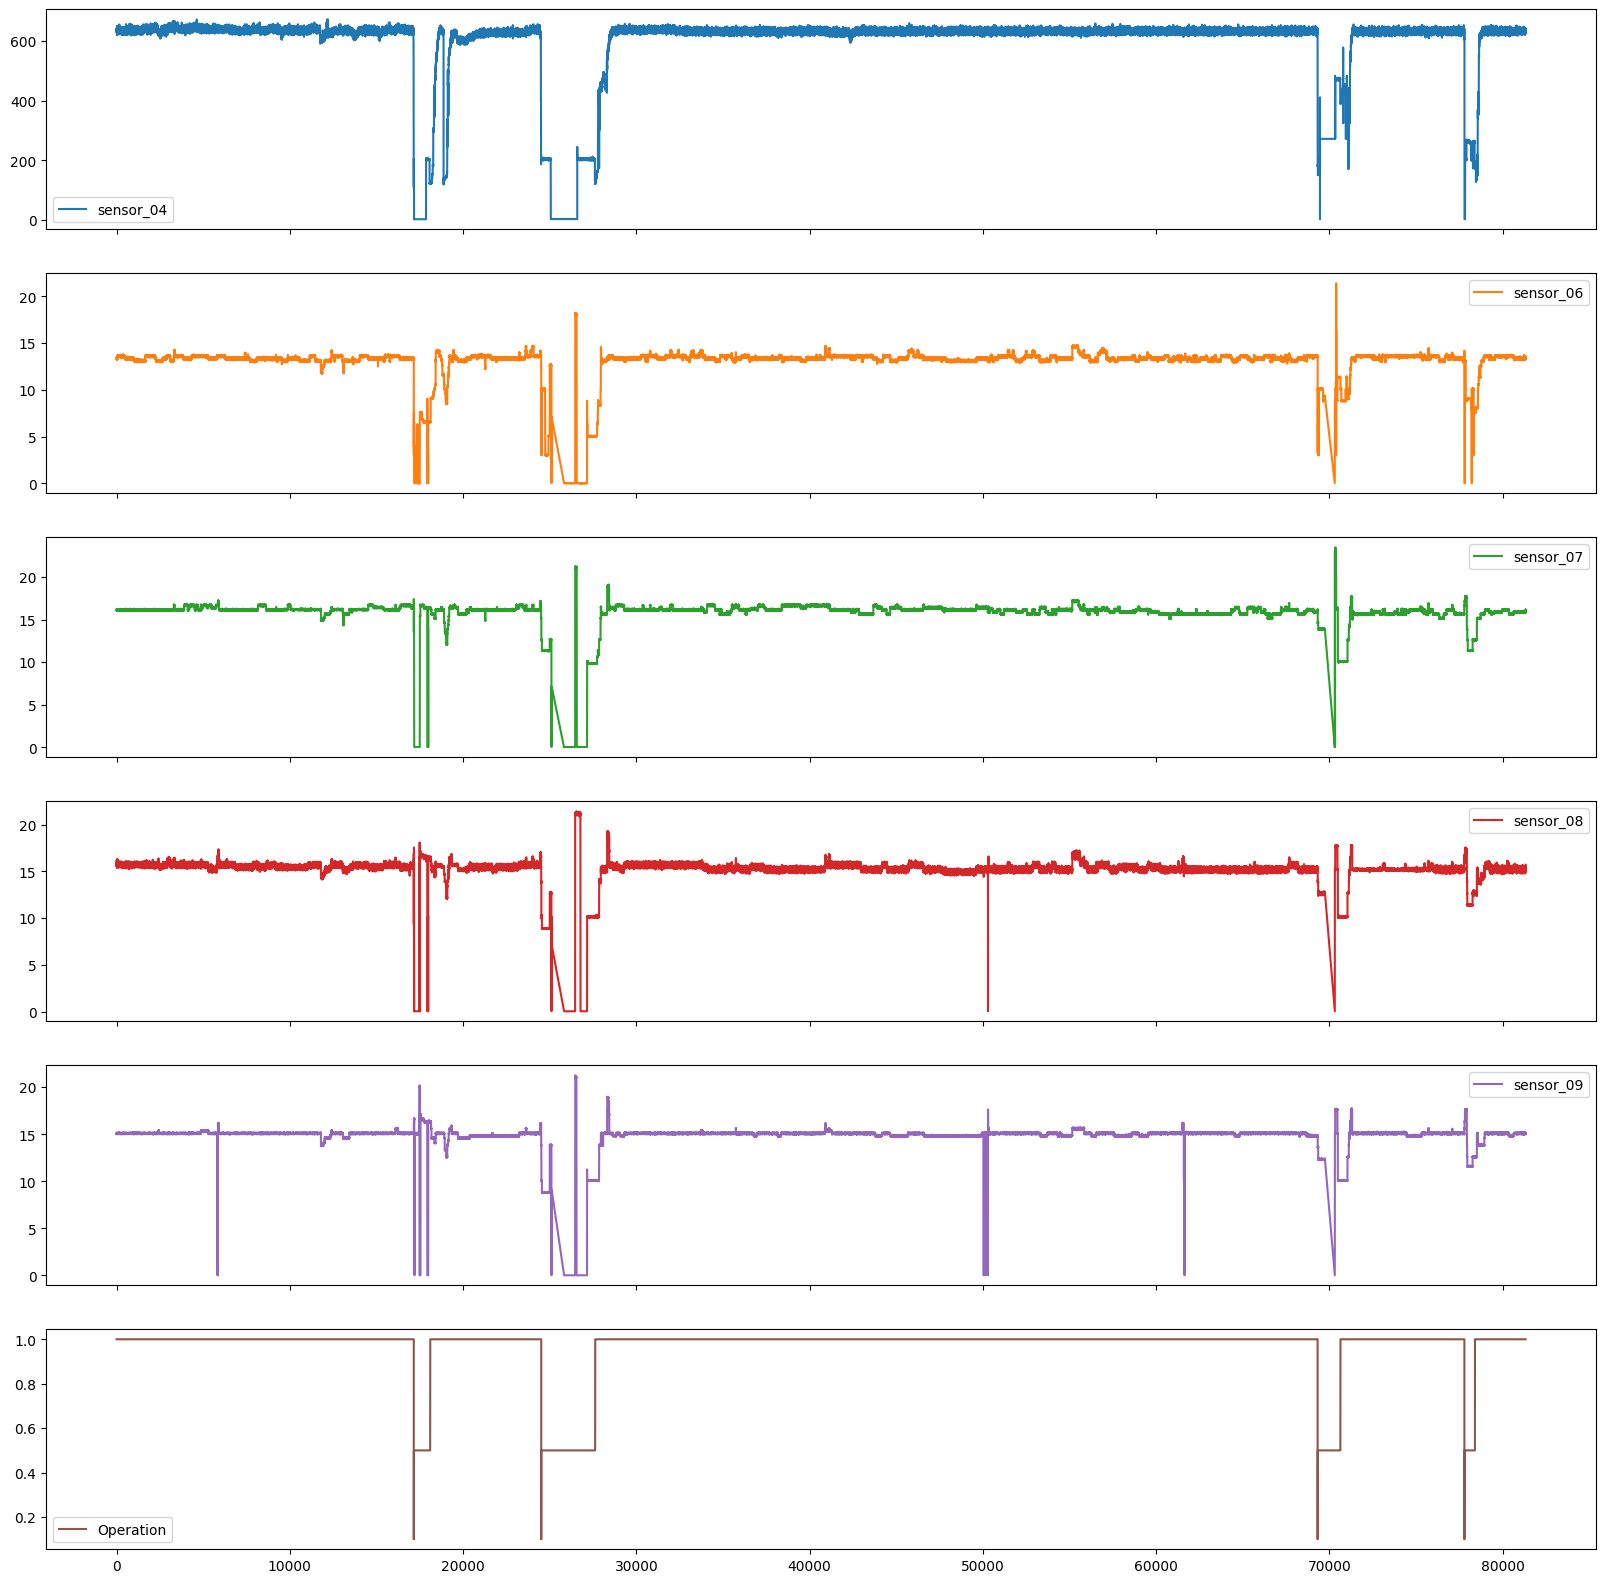

In [14]:
df.plot(subplots =True, sharex = True, figsize = (20,20))

In [15]:
df.shape

(80000, 6)

Training set:
We choose 50,000 data points with 2 broken points to train the model,

Testing set:
the remaining 170,000 points with 5 broken states will be used to test the predictivity of the model.

In [16]:
seq_length = 20
batch = 100
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
test_set = df[train_size-seq_length:]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

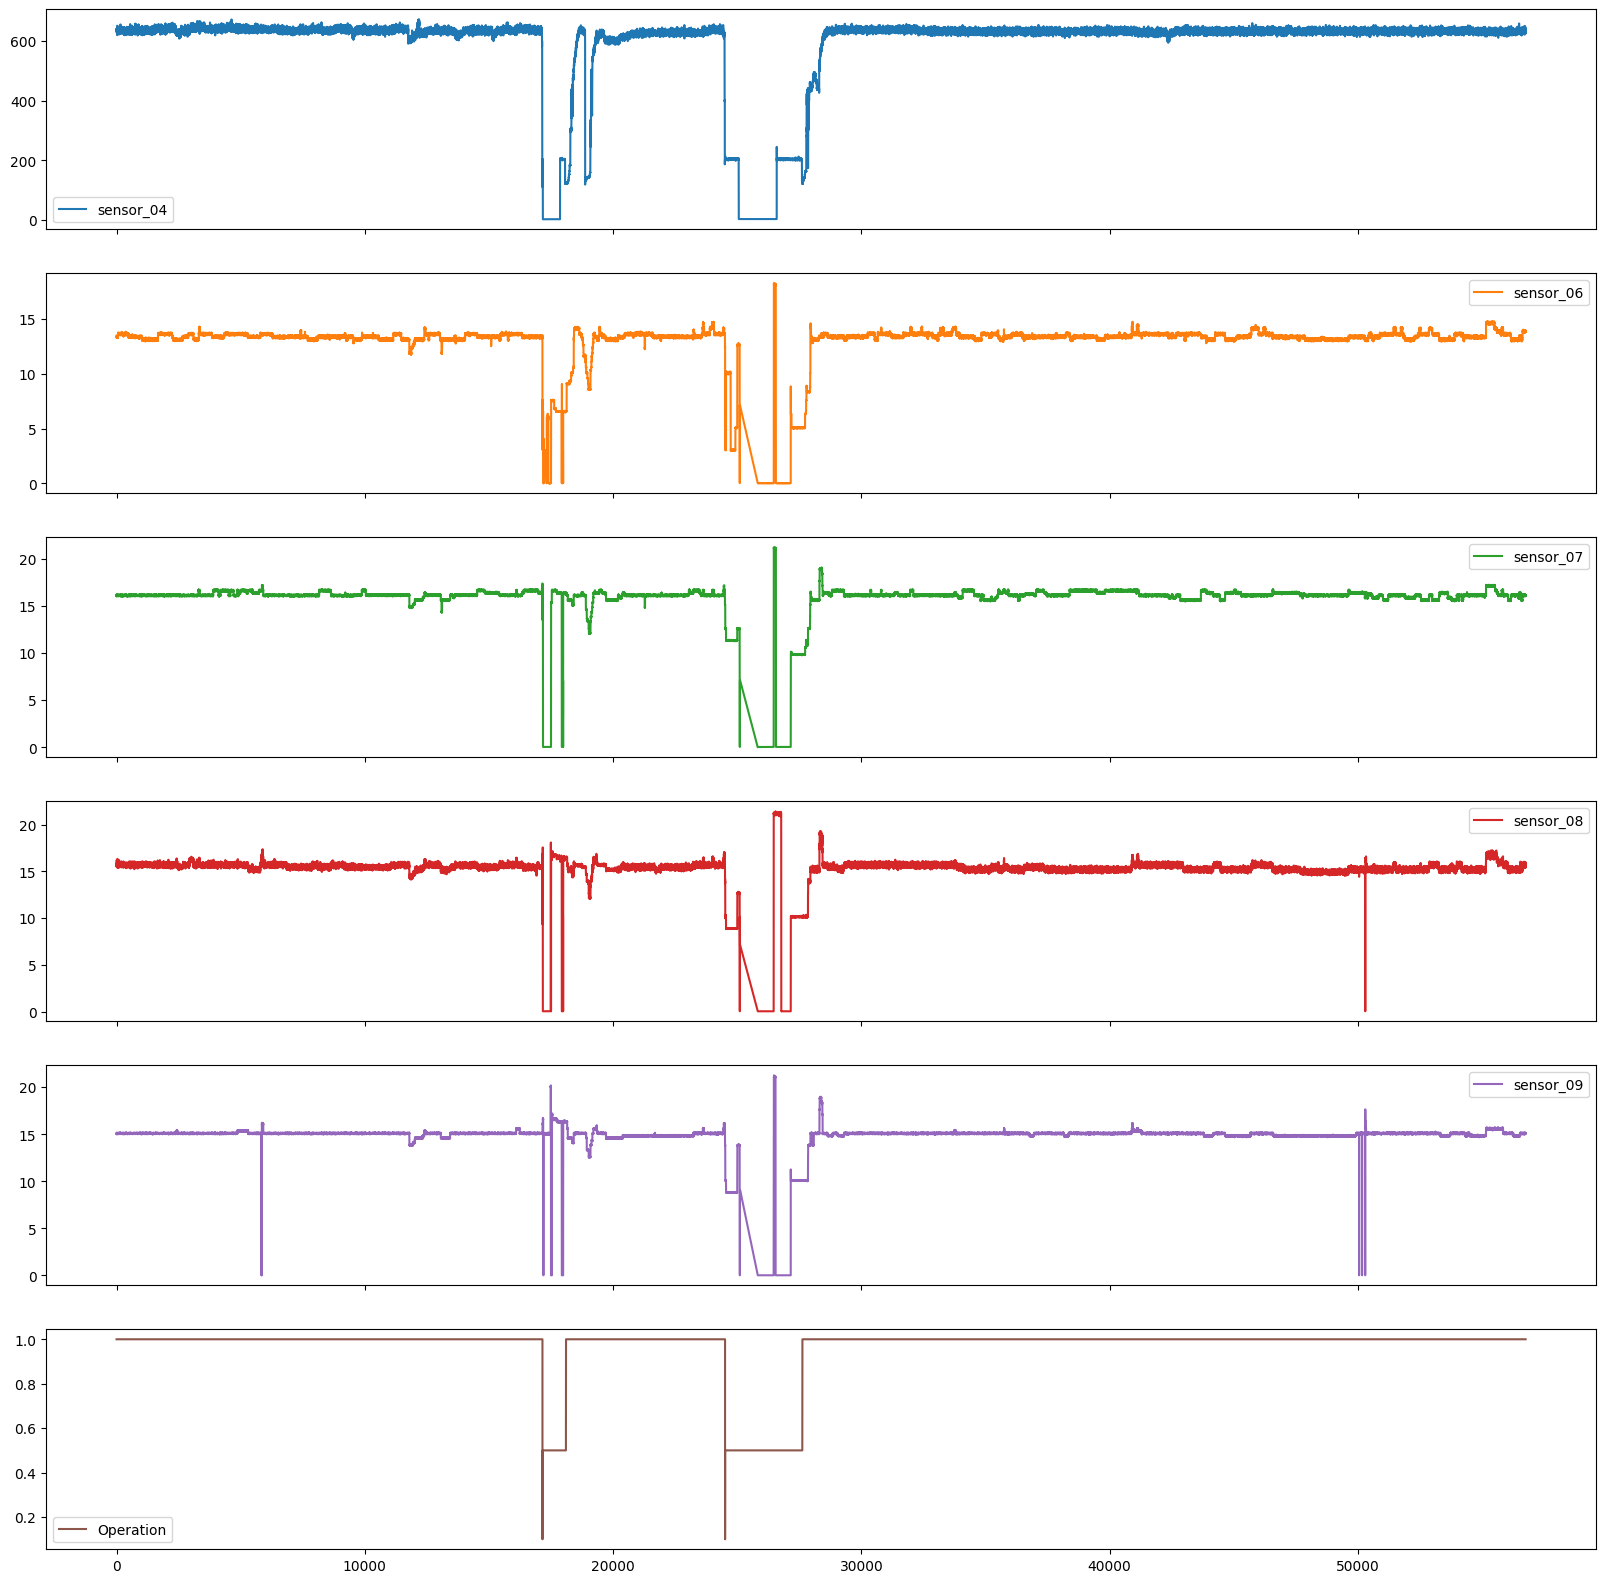

In [17]:
train_set.plot(subplots =True, sharex = True, figsize = (20,20))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

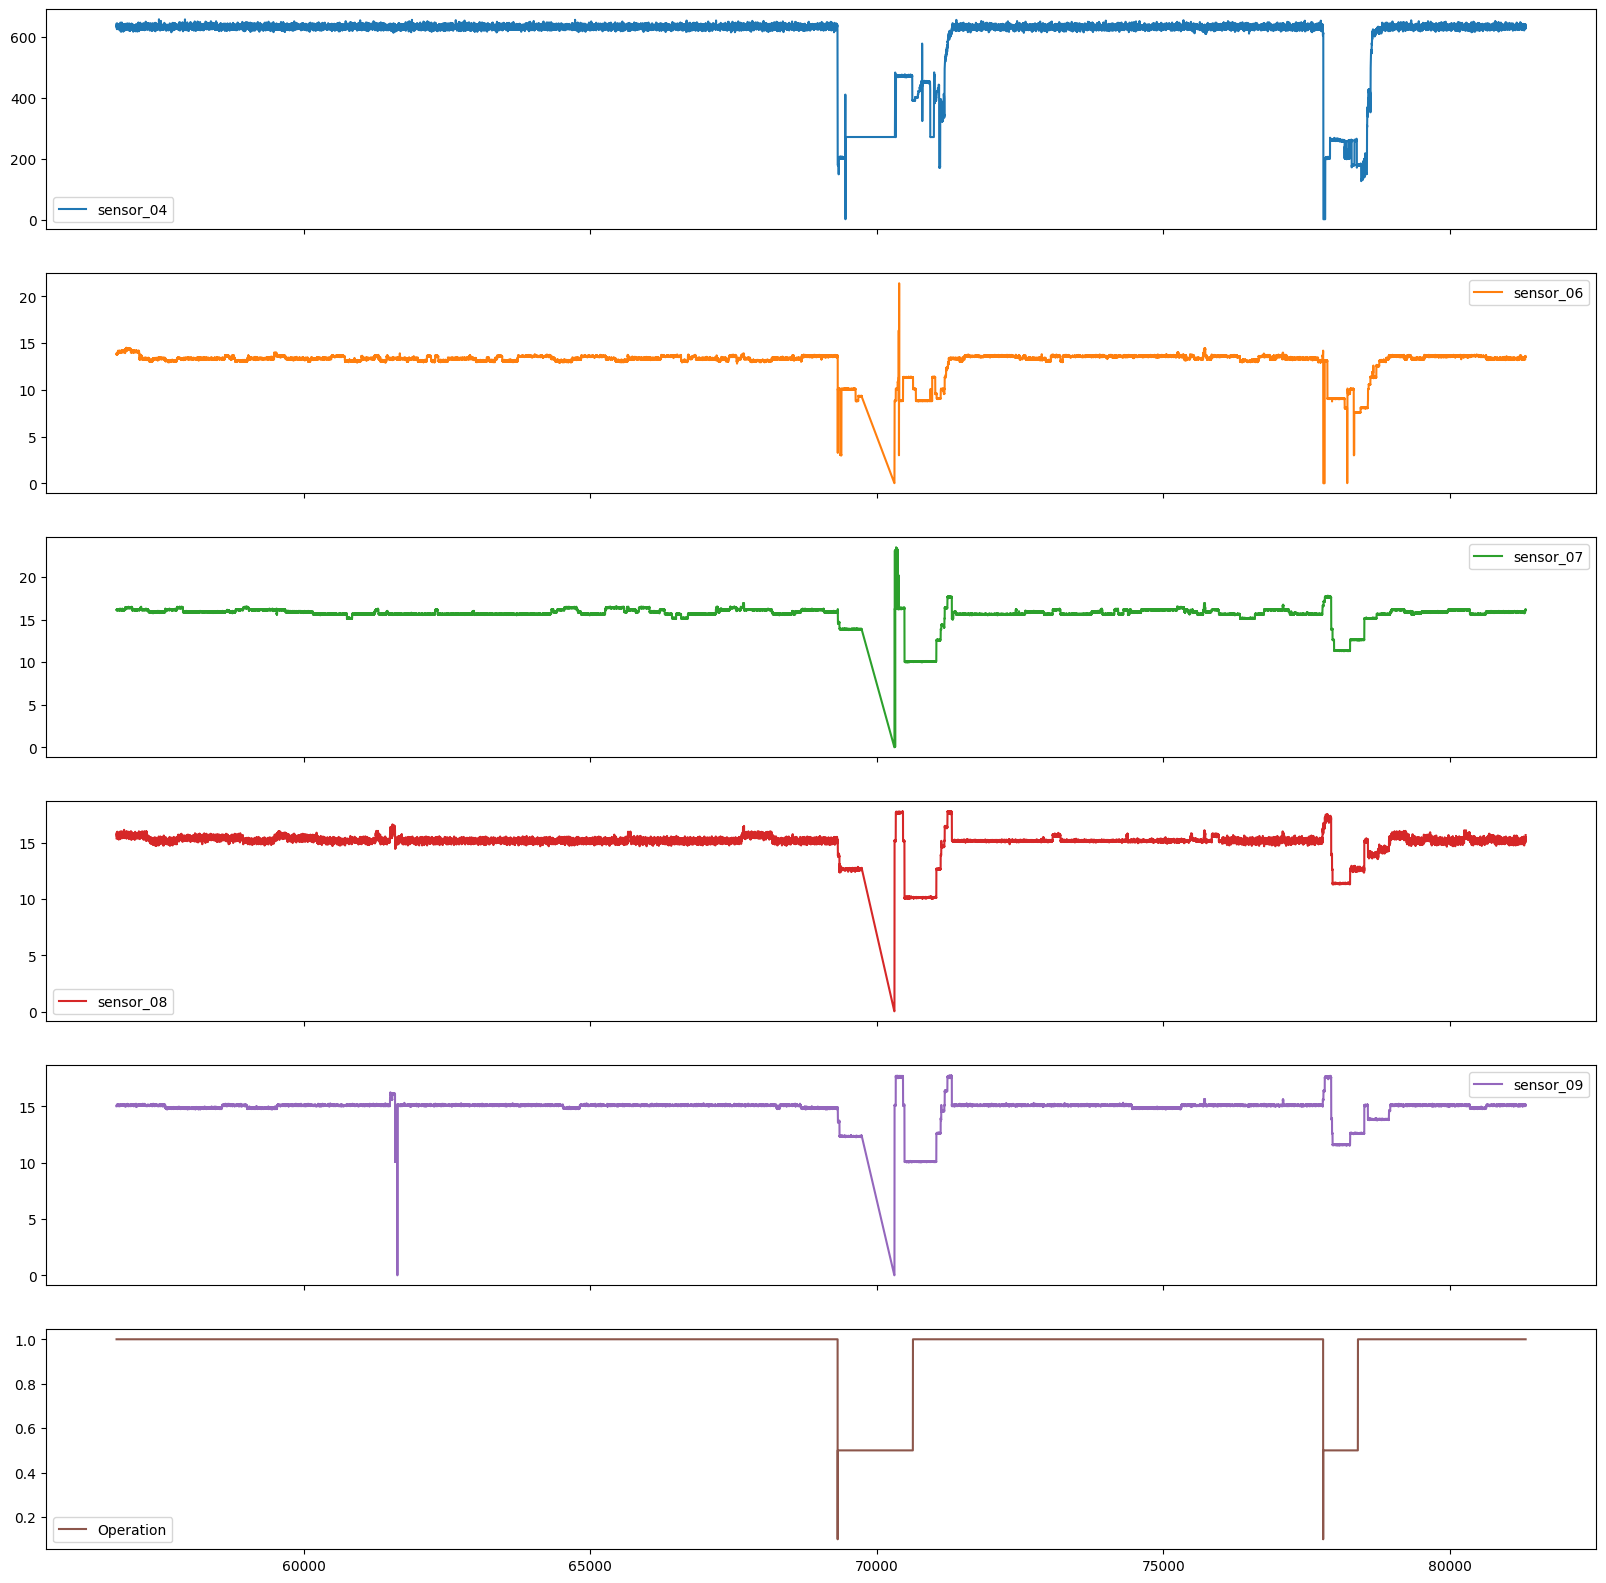

In [18]:
test_set.plot(subplots =True, sharex = True, figsize = (20,20))

In [19]:
train_set.head()

,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,Operation
0,634.3750,13.41146,16.13136,15.56713,15.05353,1.0
1,634.3750,13.41146,16.13136,15.56713,15.05353,1.0
2,638.8889,13.32465,16.03733,15.61777,15.01013,1.0
3,628.1250,13.31742,16.24711,15.69734,15.08247,1.0
4,636.4583,13.35359,16.21094,15.69734,15.08247,1.0


In [20]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(df.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(df.iloc[:, [-1]])

train_set.iloc[:, [-1]] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, [-1]] = scaler_y.transform(test_set.iloc[:, [-1]])

In [21]:
train_set.head()

,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,Operation
0,0.943783,0.626734,0.686154,0.726412,0.707483,1.0
1,0.943783,0.626734,0.686154,0.726412,0.707483,1.0
2,0.950529,0.622673,0.682154,0.728779,0.705442,1.0
3,0.934442,0.622335,0.691077,0.732499,0.708844,1.0
4,0.946897,0.624027,0.689539,0.732499,0.708844,1.0


In [22]:
train_set.describe()

,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,Operation
count,56000.000000,56000.000000,56000.000000,56000.000000,56000.000000,56000.000000
mean,0.881658,0.596468,0.664730,0.698809,0.684802,0.967157
std,0.201935,0.119394,0.120892,0.121086,0.116989,0.131087
min,-0.002906,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.930464,0.615567,0.686154,0.708488,0.700340,1.000000
50%,0.939459,0.624027,0.687692,0.721001,0.708844,1.000000
75%,0.947243,0.633841,0.697231,0.730470,0.710544,1.000000
max,1.000000,0.851776,0.904923,1.000000,1.000000,1.000000


In [23]:
device = torch.device('cpu')
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)


# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

testX_tensor = testX_tensor.to(device)
testY_tensor = testY_tensor.to(device)
# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True)

In [24]:
trainX_tensor.shape

torch.Size([55980, 20, 6])

In [25]:
testX_tensor.shape

torch.Size([24000, 20, 6])

In [26]:
print(trainX_tensor[0:2])

tensor([[[0.9438, 0.6267, 0.6862, 0.7264, 0.7075, 1.0000],
         [0.9438, 0.6267, 0.6862, 0.7264, 0.7075, 1.0000],
         [0.9505, 0.6227, 0.6822, 0.7288, 0.7054, 1.0000],
         [0.9344, 0.6223, 0.6911, 0.7325, 0.7088, 1.0000],
         [0.9469, 0.6240, 0.6895, 0.7325, 0.7088, 1.0000],
         [0.9486, 0.6267, 0.6877, 0.7416, 0.7126, 1.0000],
         [0.9422, 0.6277, 0.6862, 0.7305, 0.7088, 1.0000],
         [0.9382, 0.6193, 0.6858, 0.7558, 0.7088, 1.0000],
         [0.9402, 0.6210, 0.6862, 0.7220, 0.7105, 1.0000],
         [0.9549, 0.6254, 0.6911, 0.7288, 0.7105, 1.0000],
         [0.9488, 0.6267, 0.6877, 0.7305, 0.7105, 1.0000],
         [0.9457, 0.6267, 0.6877, 0.7396, 0.7105, 1.0000],
         [0.9374, 0.6237, 0.6877, 0.7342, 0.7054, 1.0000],
         [0.9502, 0.6223, 0.6877, 0.7396, 0.7129, 1.0000],
         [0.9408, 0.6257, 0.6862, 0.7247, 0.7092, 1.0000],
         [0.9557, 0.6240, 0.6895, 0.7210, 0.7109, 1.0000],
         [0.9376, 0.6217, 0.6877, 0.7416, 0.7088, 1.0000

LSTM

In [27]:

# 설정값
data_dim = 6
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

Training

In [28]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping : %04d epoch' %(epoch))

                break

    return model.eval(), train_hist

학습 시작

In [29]:
# 모델 학습
# 설정값
data_dim = 6
output_dim = 1
hidden_dim = 10
learning_rate = 0.001
nb_epochs = 30
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 5, patience = 10)

Epoch: 0000 train loss : 0.0562


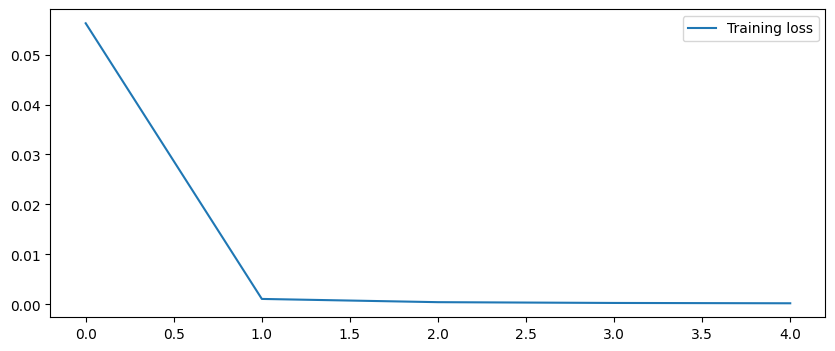

In [30]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [35]:
# # 모델 저장
PATH ='model2/model01.pth'
# #torch.save(model.state_dict(), PATH)

# # 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(6, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
print(testX_tensor[0:2])
print(testY_tensor[0:2])

tensor([[[-0.0029,  0.0296,  0.0293,  0.0323,  0.0328,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0327,  0.0330,  1.0000],
         [-0.0029,  0.0294,  0.0293,  0.0331,  0.0330,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0334,  0.0328,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0327,  0.0330,  1.0000],
         [-0.0029,  0.0299,  0.0292,  0.0326,  0.0331,  1.0000],
         [-0.0029,  0.0297,  0.0291,  0.0332,  0.0331,  1.0000],
         [-0.0029,  0.0295,  0.0293,  0.0329,  0.0330,  1.0000],
         [-0.0029,  0.0297,  0.0293,  0.0330,  0.0332,  1.0000],
         [-0.0029,  0.0299,  0.0294,  0.0329,  0.0331,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0322,  0.0331,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0322,  0.0331,  1.0000],
         [-0.0029,  0.0297,  0.0293,  0.0323,  0.0331,  1.0000],
         [-0.0029,  0.0295,  0.0291,  0.0335,  0.0331,  1.0000],
         [-0.0029,  0.0296,  0.0293,  0.0324,  0.0330,  1.0000],
         [-0.0029,  0.029

In [37]:
# 예측 테스트
a=12500
testX_tensor_2000=testX_tensor[a:a+200]
testY_tensor_2000=testY_tensor[a:a+200]
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor_2000)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor_2000[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor_2000)

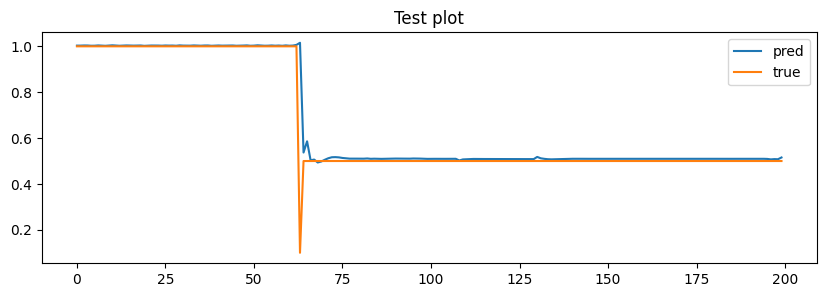

In [38]:
fig = plt.figure(figsize=(10,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Test plot")
plt.legend()
plt.show()